# Creating MobileNetV3 Neural Network from scratch

## Loading the [Data](https://pytorch.org/docs/stable/_modules/torchvision/datasets/cifar.html#CIFAR10) and looking into it

На этом этапе мы загрузим датасэт CIFAR10 и быстро изучим его. 

Стандартная процедура:

In [1]:
# 1 time download of torchvisoin into our environment
#! pip install torchvision

In [2]:
import numpy as np
import torch
from torchvision import utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor (png to tensor and normalization) 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))     #means and std dev for the CIFAR10 dataset
    ])

# downloading training and testing datasets from torchvision and saving them in /data directory
train_data = datasets.CIFAR10(root ='data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(train_data)

50000

In [5]:
set(train_data.targets)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [6]:
# WHY DOESNT THIS WORK ?
#train_data.targets.bincount()

In [7]:
# a little investigation into our data

sample = next(iter(train_data))
image, label = sample
image.shape

torch.Size([3, 32, 32])

image has 3 channels with 32 by 32 pixels

In [8]:
batch = next(iter(train_loader))
images, labels = batch
images.shape

torch.Size([20, 3, 32, 32])

In [9]:
import matplotlib.pyplot as plt

labels:  tensor([3, 5, 7, 6, 9, 7, 7, 2, 5, 3, 3, 8, 6, 8, 5, 8, 4, 9, 1, 1])


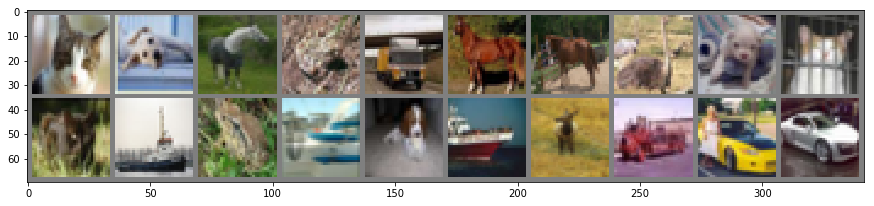

In [10]:
grid = utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid/2+0.5, (1,2,0)))
print('labels: ', labels)

### Now we have encountered some error, that was crashing our kernel. After some research we try this to avoid the error:

In [11]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

#conda install nomkl

In [12]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
def _make_divisible(v, divisor=8, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

# this function here works as a linear approximation of sigmoid (hard sigmoid)
class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)
        
    def forward(self, x):
        out = self.relu(x + 3)/6
        return out
    
    
# this function is a linear approximation of swish (hard swish)
class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)
        
    def forward(self, x):
        out = x*self.sigmoid(x)
        return out

    
# attempting to create squeeze-and-excite layer
class SE_layer(nn.Module):
    def __init__(self, exp_size, divide=4):
        super(SE_layer, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(exp_size, exp_size//divide),
            nn.ReLU(inplace=True),
            nn.Linear(exp_size // divide, exp_size),
            h_sigmoid()
        )
        
    def forward(self, x):
        batch, channels, height, width = x.size()
        out = F.avg_pool2d(x, kernel_size=[height, width]).view(batch, -1)
        out = self.dense(out)
        out = out.view(batch, channels, 1, 1)
        out = out*x
        return out


class MobileBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernal_size, stride, activation_function,exp_size): # RENAME THESE PARAMETERS
        super(MobileBlock, self).__init__()
        
        self.out_channels = out_channels
        self.activation_function = activation_function
        # WHAT IS THIS HERE ??????????????                        <============================== ??????????????
        padding = (kernal_size - 1) // 2
        
        #making sure that the ??????????????????                        <====================== HOW TO MAKE THIS
        self.connection = (stride == 1 and in_channels == out_channels)

        if self.activation_function == "RE":
            activation = nn.ReLU
        else:
            activation = h_swish

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, exp_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(exp_size),
            activation(inplace=True)
        )
        self.depth_conv = nn.Sequential(
            nn.Conv2d(exp_size, exp_size, kernel_size=kernal_size, stride=stride, padding=padding, groups=exp_size),
            nn.BatchNorm2d(exp_size),
        )

        self.point_conv = nn.Sequential(
            nn.Conv2d(exp_size, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            activation(inplace=True)
        )
        
    
    def forward(self, x):
        # Taken from MobileNetV2
        out = self.conv(x)
        out = self.depth_conv(out)
        out = self.point_conv(out) # point-wise conv

        # connection
        if self.connection:
            return x + out
        else:
            return out
        
        
        
# here is the Mobile block with the Squeeze and Excite Block
class MobileBlock_SE(nn.Module):
    def __init__(self, in_channels, out_channels, kernal_size, stride, activation_function, exp_size):
        super(MobileBlock_SE, self).__init__()
        
        self.out_channels = out_channels
        self.activation_function = activation_function
        
        padding = (kernal_size - 1) // 2

        self.connection = (stride == 1 and in_channels == out_channels)

        if self.activation_function == "RE":
            activation = nn.ReLU
        else:
            activation = h_swish

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, exp_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(exp_size),
            activation(inplace=True)
        )
        self.depth_conv = nn.Sequential(
            nn.Conv2d(exp_size, exp_size, kernel_size=kernal_size, stride=stride, padding=padding, groups=exp_size),
            nn.BatchNorm2d(exp_size),
        )

        self.squeeze_block = SE_layer(exp_size)

        self.point_conv = nn.Sequential(
            nn.Conv2d(exp_size, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            activation(inplace=True)
        )
        
        
    def forward(self, x):
        # taken from MobileNetV2
        out = self.conv(x)
        out = self.depth_conv(out)
        out = self.squeeze_block(out) # Squeeze and Excite
        out = self.point_conv(out) # point-wise conv

        # connection type
        if self.connection:
            return x + out
        else:
            return out
        
        


class MobileNetV3_large(nn.Module):
    def __init__(self, num_classes=10, multiplier=1.0, dropout_rate=0.0):
        super(MobileNetV3_large, self).__init__()
        self.num_classes = num_classes
        # what does the first line do and why is it here       ???????                 <==================
        init_conv_out = _make_divisible(16 * multiplier)
        
        # first layer
        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=init_conv_out, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(init_conv_out),
            h_swish(inplace=True)
        )
        
        self.block = nn.Sequential(
            MobileBlock(_make_divisible(16), _make_divisible(16), 3, 1, "RE", _make_divisible(16)),
            MobileBlock(_make_divisible(16), _make_divisible(24), 3, 2, "RE", _make_divisible(64)),
            MobileBlock(_make_divisible(24), _make_divisible(24), 3, 1, "RE", _make_divisible(72)),
            MobileBlock_SE(_make_divisible(24), _make_divisible(40), 5, 2, "RE", _make_divisible(72)),
            MobileBlock_SE(_make_divisible(40), _make_divisible(40), 5, 1, "RE", _make_divisible(120)),
            MobileBlock_SE(_make_divisible(40), _make_divisible(40), 5, 1, "RE", _make_divisible(120)),
            MobileBlock(_make_divisible(40), _make_divisible(80), 3, 2, "HS", _make_divisible(240)),
            MobileBlock(_make_divisible(80), _make_divisible(80), 3, 1, "HS", _make_divisible(200)),
            MobileBlock(_make_divisible(80), _make_divisible(80), 3, 1, "HS", _make_divisible(184)),
            MobileBlock(_make_divisible(80), _make_divisible(80), 3, 1, "HS", _make_divisible(184)),
            MobileBlock_SE(_make_divisible(80), _make_divisible(112), 3, 1, "HS", _make_divisible(480)),
            MobileBlock_SE(_make_divisible(112), _make_divisible(112), 3, 1, "HS", _make_divisible(672)),
            MobileBlock_SE(_make_divisible(112), _make_divisible(160), 5, 1, "HS", _make_divisible(672)),
            MobileBlock_SE(_make_divisible(160), _make_divisible(160), 5, 2, "HS", _make_divisible(672)),
            MobileBlock_SE(_make_divisible(160), _make_divisible(160), 5, 1, "HS", _make_divisible(960))
        )
        
        out_conv1_in = _make_divisible(160 * multiplier)
        out_conv1_out = _make_divisible(960 * multiplier)
        self.out_conv1 = nn.Sequential(
            nn.Conv2d(out_conv1_in, out_conv1_out, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_conv1_out),
            h_swish(inplace=True),
        )
        
        out_conv2_in = _make_divisible(960 * multiplier)
        out_conv2_out = _make_divisible(1280 * multiplier)
        self.out_conv2 = nn.Sequential(
            nn.Conv2d(out_conv2_in, out_conv2_out, kernel_size=1, stride=1),
            h_swish(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(out_conv2_out, self.num_classes, kernel_size=1, stride=1),
        )
        

    def forward(self, x):
        out = self.init_conv(x)
        out = self.block(out)
        out = self.out_conv1(out)
        batch, channels, height, width = out.size()
        out = F.avg_pool2d(out, kernel_size=[height, width])
        out = self.out_conv2(out).view(batch, -1)
        
        return out
        

In [14]:
class MobileNetV3_large(nn.Module):
    """
    MobileNetV3_large model taken from Table 1, of the paper of interest
    """
    def __init__(self, num_classes=10, multiplier=1.0, dropout_rate=0.0):
        super(MobileNetV3_large, self).__init__()
        self.num_classes = num_classes
        init_conv_out = _make_divisible(16 * multiplier)

        # first layer
        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=init_conv_out, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(init_conv_out),
            h_swish(inplace=True)
        )

        self.block = nn.Sequential(
            MobileBlock(_make_divisible(16), _make_divisible(16), 3, 1, "RE", _make_divisible(16)),
            MobileBlock(_make_divisible(16), _make_divisible(24), 3, 2, "RE", _make_divisible(64)),
            MobileBlock(_make_divisible(24), _make_divisible(24), 3, 1, "RE", _make_divisible(72)),
            MobileBlock_SE(_make_divisible(24), _make_divisible(40), 5, 2, "RE", _make_divisible(72)),
            MobileBlock_SE(_make_divisible(40), _make_divisible(40), 5, 1, "RE", _make_divisible(120)),
            MobileBlock_SE(_make_divisible(40), _make_divisible(40), 5, 1, "RE", _make_divisible(120)),
            MobileBlock(_make_divisible(40), _make_divisible(80), 3, 2, "HS", _make_divisible(240)),
            MobileBlock(_make_divisible(80), _make_divisible(80), 3, 1, "HS", _make_divisible(200)),
            MobileBlock(_make_divisible(80), _make_divisible(80), 3, 1, "HS", _make_divisible(184)),
            MobileBlock(_make_divisible(80), _make_divisible(80), 3, 1, "HS", _make_divisible(184)),
            MobileBlock_SE(_make_divisible(80), _make_divisible(112), 3, 1, "HS", _make_divisible(480)),
            MobileBlock_SE(_make_divisible(112), _make_divisible(112), 3, 1, "HS", _make_divisible(672)),
            MobileBlock_SE(_make_divisible(112), _make_divisible(160), 5, 1, "HS", _make_divisible(672)),
            MobileBlock_SE(_make_divisible(160), _make_divisible(160), 5, 2, "HS", _make_divisible(672)),
            MobileBlock_SE(_make_divisible(160), _make_divisible(160), 5, 1, "HS", _make_divisible(960))
        )

        out_conv1_in = _make_divisible(160 * multiplier)
        out_conv1_out = _make_divisible(960 * multiplier)
        self.out_conv1 = nn.Sequential(
            nn.Conv2d(out_conv1_in, out_conv1_out, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_conv1_out),
            h_swish(inplace=True),
        )

        out_conv2_in = _make_divisible(960 * multiplier)
        out_conv2_out = _make_divisible(1280 * multiplier)
        self.out_conv2 = nn.Sequential(
            nn.Conv2d(out_conv2_in, out_conv2_out, kernel_size=1, stride=1),
            h_swish(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(out_conv2_out, self.num_classes, kernel_size=1, stride=1),
        )


    def forward(self, x):
        out = self.init_conv(x)
        out = self.block(out)
        out = self.out_conv1(out)
        batch, channels, height, width = out.size()
        out = F.avg_pool2d(out, kernel_size=[height, width])
        out = self.out_conv2(out).view(batch, -1)

        return out



In [15]:
MobileNetV3_large_test = MobileNetV3_large(num_classes = 10)

In [16]:
import time

In [17]:
# timing 1 single batch training
start = time.time()

MobileNetV3_large_test = MobileNetV3_large(10)
optimizer = optim.SGD(MobileNetV3_large_test.parameters(), lr = 0.045)

batch = next(iter(train_loader))
images, labels = batch

preds = MobileNetV3_large_test(images)
loss = F.cross_entropy(preds, labels)

loss.backward()
optimizer.step()

end = time.time()
#================================================
print('Total elapsed time to train the single batch is: ', end-start)

print('loss_1: ', loss.item())
preds = MobileNetV3_large_test(images)
loss = F.cross_entropy(preds, labels)
print('loss_2: ', loss.item())

Total elapsed time to train the single batch is:  2.0133769512176514
loss_1:  2.3370301723480225
loss_2:  2.263167142868042


In [ ]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

In [ ]:
model.load_state_dict(torch.load('model_cifar.pt'))

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))